In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from LoadData import loaddata, filter_zeroes, filter_data
import torch

simulation_names = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine']
data = loaddata(simulation_names)
filtered_AH, filtered_mass_presentsfr, filtered_labels = filter_data(data) # Removes galaxies with all 0 SFHs

In [2]:
filtered_AH.shape, filtered_mass_presentsfr.shape, filtered_labels.shape # Sanity check

((63083, 139), (63083, 2), (63083,))

In [3]:
import random
# Set seed for reproducibility
seed = 130
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For CUDA
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # Ensures determinism

In [4]:
from Model import ConvAutoencoder
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR

device = torch.device("mps") # MPS on Mac

In [5]:
import torch
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset

# Split into 80% Train+Validation and 20% Test
SFH_train_val, SFH_test, labels_train_val, labels_test, mass_sfr_train_val, mass_sfr_test = train_test_split(
    filtered_AH, filtered_labels, filtered_mass_presentsfr, test_size=0.2, random_state=42)

# Test set will be untouched during K fold
SFH_test_tensor = torch.tensor(SFH_test, dtype=torch.float32)
labels_test_tensor = torch.tensor(labels_test, dtype=torch.float32)
mass_sfr_test_tensor = torch.tensor(mass_sfr_test, dtype=torch.float32)

test_dataset = TensorDataset(SFH_test_tensor, labels_test_tensor, mass_sfr_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

# Train+Val will be used to perform K fold
SFH_train_val_tensor = torch.tensor(SFH_train_val, dtype=torch.float32)
labels_train_val_tensor = torch.tensor(labels_train_val, dtype=torch.float32)
mass_sfr_train_val_tensor = torch.tensor(mass_sfr_train_val, dtype=torch.float32)

# K fold time!!
K = 5  # Number of folds
kf = KFold(n_splits=K, shuffle=True, random_state=42)

# Store fold results
fold_results = []

In [6]:
from Model import train

# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(SFH_train_val_tensor)):
    print(f"Fold {fold+1}/{K}")

    SFH_train, SFH_val = SFH_train_val_tensor[train_idx], SFH_train_val_tensor[val_idx]
    labels_train, labels_val = labels_train_val_tensor[train_idx], labels_train_val_tensor[val_idx]
    mass_sfr_train, mass_sfr_val = mass_sfr_train_val_tensor[train_idx], mass_sfr_train_val_tensor[val_idx]

    train_dataset = TensorDataset(SFH_train, labels_train, mass_sfr_train)
    val_dataset = TensorDataset(SFH_val, labels_val, mass_sfr_val)

    train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)

    AE = ConvAutoencoder().to(device)
    optimizer = optim.Adam(AE.parameters(), lr=0.01)

    scheduler = CyclicLR(
        optimizer, 
        base_lr=0.005,  # min
        max_lr=0.02,     # max
        step_size_up=100,  
        mode='triangular2'  
    )
    losses, losses_mass_sfr, losses_sfh, losses_sim_type = train(AE, 50, device, optimizer, scheduler, train_loader, val_loader)
    print(f'Finished training for fold #{fold+1}')

    fold_results.append([losses, losses_mass_sfr, losses_sfh, losses_sim_type])
    torch.save(AE, f"model{fold+1}.pth")

Fold 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([50, 139])) that is different to the input size (torch.Size([50, 1, 139])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([44, 139])) that is different to the input size (torch.Size([44, 1, 139])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [0/50], Training Loss: 7.7724, Val Loss: 14.0122, SFH Loss: 12.3067, Sim Type Loss: 1.3307, Mass-SFR Loss: 0.3748
Epoch [1/50], Training Loss: 4.8593, Val Loss: 14.5196, SFH Loss: 12.9664, Sim Type Loss: 1.1963, Mass-SFR Loss: 0.3568
Epoch [2/50], Training Loss: 4.5435, Val Loss: 13.7774, SFH Loss: 12.7227, Sim Type Loss: 0.7340, Mass-SFR Loss: 0.3207
Epoch [3/50], Training Loss: 4.1677, Val Loss: 13.3595, SFH Loss: 12.4692, Sim Type Loss: 0.5854, Mass-SFR Loss: 0.3049
Epoch [4/50], Training Loss: 3.7571, Val Loss: 13.8431, SFH Loss: 13.2228, Sim Type Loss: 0.4125, Mass-SFR Loss: 0.2077
Epoch [5/50], Training Loss: 3.5047, Val Loss: 13.9274, SFH Loss: 13.3702, Sim Type Loss: 0.3481, Mass-SFR Loss: 0.2091
Epoch [6/50], Training Loss: 3.3259, Val Loss: 13.3180, SFH Loss: 12.6465, Sim Type Loss: 0.4086, Mass-SFR Loss: 0.2629
Epoch [7/50], Training Loss: 3.1488, Val Loss: 13.7373, SFH Loss: 13.3666, Sim Type Loss: 0.2253, Mass-SFR Loss: 0.1454
Epoch [8/50], Training Loss: 3.0926, Val

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([43, 139])) that is different to the input size (torch.Size([43, 1, 139])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [0/50], Training Loss: 6.6952, Val Loss: 14.0742, SFH Loss: 12.6904, Sim Type Loss: 1.0342, Mass-SFR Loss: 0.3497
Epoch [1/50], Training Loss: 4.1799, Val Loss: 13.6513, SFH Loss: 12.6026, Sim Type Loss: 0.7506, Mass-SFR Loss: 0.2981
Epoch [2/50], Training Loss: 3.6495, Val Loss: 14.2646, SFH Loss: 13.5191, Sim Type Loss: 0.5170, Mass-SFR Loss: 0.2286
Epoch [3/50], Training Loss: 3.3971, Val Loss: 12.9520, SFH Loss: 12.2698, Sim Type Loss: 0.4591, Mass-SFR Loss: 0.2230
Epoch [4/50], Training Loss: 3.2400, Val Loss: 13.7323, SFH Loss: 13.1768, Sim Type Loss: 0.3328, Mass-SFR Loss: 0.2228
Epoch [5/50], Training Loss: 3.1202, Val Loss: 14.1731, SFH Loss: 13.5817, Sim Type Loss: 0.3475, Mass-SFR Loss: 0.2439
Epoch [6/50], Training Loss: 3.0263, Val Loss: 13.7641, SFH Loss: 13.2629, Sim Type Loss: 0.2820, Mass-SFR Loss: 0.2192
Epoch [7/50], Training Loss: 2.9087, Val Loss: 13.9384, SFH Loss: 13.4855, Sim Type Loss: 0.2665, Mass-SFR Loss: 0.1863
Epoch [8/50], Training Loss: 2.8392, Val

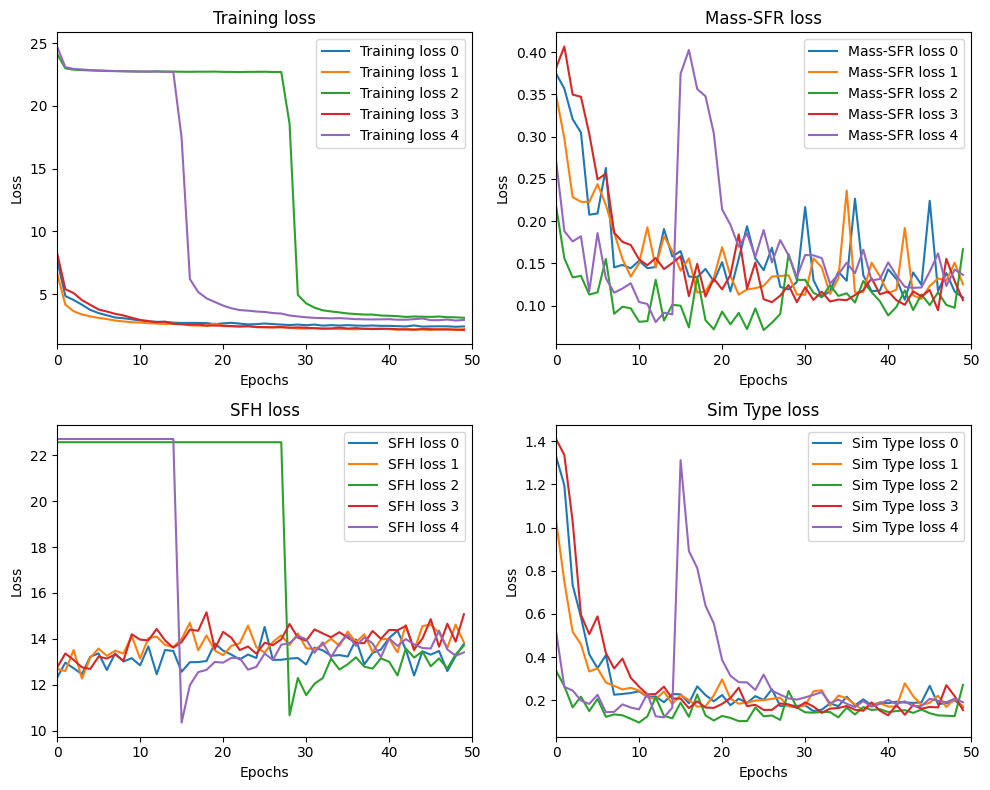

In [49]:
loss_labels = ['Training loss', 'Mass-SFR loss', 'SFH loss', 'Sim Type loss']

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for loss_idx, ax in enumerate(axes.flat):
    for i in range(5):
        ax.plot(fold_results[i][loss_idx], label=f'{loss_labels[loss_idx]} {i}')
    
    ax.set_xlim(0, 50)
    ax.set_title(loss_labels[loss_idx])
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()

plt.tight_layout()
plt.show()

# Some seem to converge later, but all converge eventually. Getting stuck at 22 for SFH loss means it's predicting
# the mean/making all zero predictions


In [6]:
AE1 = torch.load('model1.pth')
AE2 = torch.load('model2.pth')
AE3 = torch.load('model3.pth')
AE4 = torch.load('model4.pth')
AE5 = torch.load('model5.pth')
AE = [AE1, AE2, AE3, AE4, AE5]

In [7]:
from LoadData import un_one_hot

# Using the untouched test set from earlier to evaluate sim prediction accuracy
y_preds = []
latent_spaces = []
for j in range(5):
    with torch.no_grad():
        y_preds.append(AE[j](SFH_test_tensor.unsqueeze(1).to(device))) # List of 5 sets of model predictions
        # for models trained on the 5 fold respectively
        latent_spaces.append(AE[j].encoder(SFH_test_tensor.unsqueeze(1).to(device)))
        # Also loading their latent spaces, although not really using that rn

    sim_pred = un_one_hot(y_preds[j][1].detach().cpu().numpy())

    correct = 0
    for i in range(len(sim_pred)):
        if np.array_equal(sim_pred[i], labels_test[i]):
            correct += 1

    print(f'Sim accuracy for fold #{j}: {correct / len(sim_pred)}')


Sim accuracy for fold #0: 0.9384164222873901
Sim accuracy for fold #1: 0.9380201315685187
Sim accuracy for fold #2: 0.9267654751525719
Sim accuracy for fold #3: 0.9499881112784339
Sim accuracy for fold #4: 0.9299358009035429


**Pretty consistent accuracies!**
Now we train our model on 80% of the data. (The original 80% reserved for training + validation)

In [9]:
from Model import train_no_val

full_train_dataset = TensorDataset(SFH_train_val_tensor, labels_train_val_tensor, mass_sfr_train_val_tensor)
full_train_loader = DataLoader(full_train_dataset, batch_size=50, shuffle=True)

AE_final = ConvAutoencoder().to(device)
optimizer = optim.Adam(AE_final.parameters(), lr=0.01)

scheduler = CyclicLR(
    optimizer, 
    base_lr=0.005,  
    max_lr=0.02,     
    step_size_up=100,  
    mode='triangular2'  
)

losses_final = train_no_val(AE_final, 50, device, optimizer, scheduler, full_train_loader)

Epoch [0/50], Training Loss: 24.1164
Epoch [1/50], Training Loss: 22.9683
Epoch [2/50], Training Loss: 22.8491
Epoch [3/50], Training Loss: 22.8103
Epoch [4/50], Training Loss: 22.7967
Epoch [5/50], Training Loss: 22.7841
Epoch [6/50], Training Loss: 22.7725
Epoch [7/50], Training Loss: 22.7667
Epoch [8/50], Training Loss: 22.7532
Epoch [9/50], Training Loss: 22.7560
Epoch [10/50], Training Loss: 22.7416
Epoch [11/50], Training Loss: 22.7432
Epoch [12/50], Training Loss: 22.7448
Epoch [13/50], Training Loss: 22.7457
Epoch [14/50], Training Loss: 22.7254
Epoch [15/50], Training Loss: 22.7350
Epoch [16/50], Training Loss: 22.7214
Epoch [17/50], Training Loss: 16.8865
Epoch [18/50], Training Loss: 3.9370
Epoch [19/50], Training Loss: 3.3951
Epoch [20/50], Training Loss: 3.1652
Epoch [21/50], Training Loss: 3.0001
Epoch [22/50], Training Loss: 2.9514
Epoch [23/50], Training Loss: 2.8838
Epoch [24/50], Training Loss: 2.8470
Epoch [25/50], Training Loss: 2.7973
Epoch [26/50], Training Loss: 

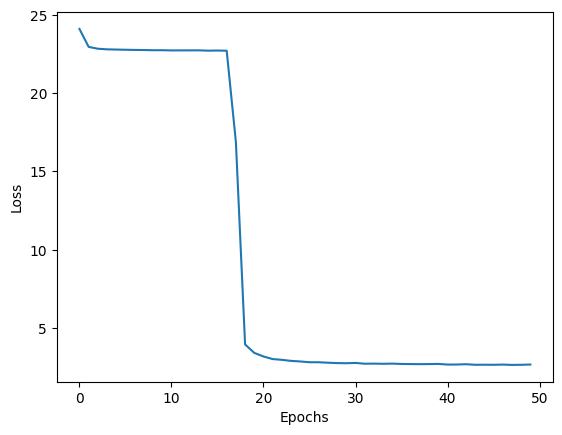

In [14]:

plt.plot(losses_final)
plt.xlabel("Epochs")
plt.ylabel("Loss")
torch.save(AE_final, f"model_full_0207.pth")

In [18]:
with torch.no_grad():
    y_pred_tensor = AE_final(SFH_test_tensor.unsqueeze(1).to(device))
    latent_space_tensor = AE_final.encoder(SFH_test_tensor.unsqueeze(1).to(device))

latent_space = latent_space_tensor.detach().cpu().numpy()
SFH_pred = y_pred_tensor[0].detach().cpu().numpy()
sim_pred = un_one_hot(y_pred_tensor[1].detach().cpu().numpy())
SMSFR_pred = y_pred_tensor[2].detach().cpu().numpy()

In [19]:
# Testing with the test set
correct = 0
for i in range(len(sim_pred)):
    if np.array_equal(sim_pred[i], labels_test[i]):
        correct += 1

print(correct / len(sim_pred))

0.926210668146152


In [20]:
import umap
reducer = umap.UMAP(n_components=2, n_neighbors=15)
embedding = reducer.fit_transform(latent_space)
embedding.shape

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(12617, 2)

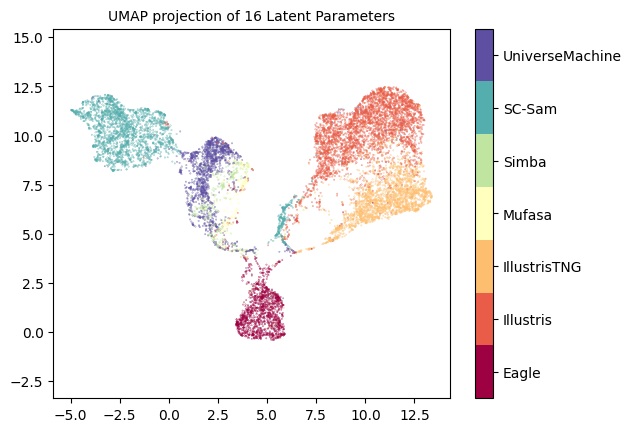

In [21]:
labels = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine']

plt.scatter(embedding[:, 0], embedding[:, 1], c=labels_test, cmap='Spectral', s=0.05)
plt.gca().set_aspect('equal', 'datalim')

cbar = plt.colorbar(boundaries=np.arange(8)-0.5, ticks=np.arange(7))
cbar.ax.set_yticklabels(labels)

plt.title('UMAP projection of 16 Latent Parameters', fontsize=10)
plt.show()